Import libraries:

In [550]:
import pandas as pd
import numpy as np
import scipy as sc
import math
import matplotlib.pyplot as plt
import matplotlib as matplotlib 
from statsmodels.tsa.stattools import adfuller
from scipy import stats
import statsmodels.api as sm
from IPython.display import Image
from celluloid import Camera
from matplotlib.animation import PillowWriter
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

Define custom classes/functions:

In [551]:
class LoopingPillowWriter(PillowWriter):
    def finish(self):
        self._frames[0].save(self._outfile, save_all=True, append_images=self._frames[1:],
                             duration=int(1000/self.fps), loop=0)

Global parameters:

In [552]:
n=20

Read Gold (daily close) data:

In [553]:
df = pd.read_csv('quotes/XAUUSD.csv') 
df.columns = ['date','time','open','high','low','close','volume'] 
df = df[['date','open','close','low','high']]
df.set_index('date',inplace=True)
df = df.drop(['high','low','open'], axis=1) 
df.index = pd.to_datetime(df.index)

Convert prices to % returns (1) by log function and taking differences (2):

In [554]:
df['return'] = df['close'].apply(np.log)
df['return'] = 100*df['return'].diff(periods=1)

Insert rollings:

In [555]:
df['return_median'] = df['return'].rolling(n).median()
df['return_mean'] = df['return'].rolling(n).mean()
df['delta']=df['return_mean']-df['return_median']
df.dropna(inplace=True)

Visual statistical description of unrescaled returns. Recent point is marked by yellow: 

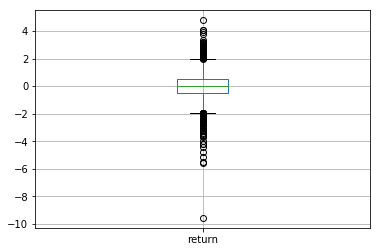

In [556]:
df[['return']].boxplot(grid=True) 
plt.show()

For Gauss PDF outliers show 3-sigma events. Outliers mark inefficiencies. Probability distribution function:

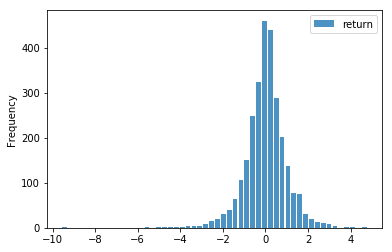

In [557]:
df[['return']].plot.hist(bins = int(np.sqrt(len(df))),rwidth = 0.8,alpha = 0.8)
plt.show()

Test for normal distribution (ND) of PDF:

In [558]:
z,p = stats.normaltest(df['return'])
print('Probability that PDF differs from Normal Distribution:',100*round(p,2),'%')

Probability that PDF differs from Normal Distribution: 0.0 %


Create visual representation. Ranges (1 sigma) of are added:

In [559]:
description=df['return'].describe()

mean = float(description.iloc[1])
std = float(description.iloc[2])

u = round(mean+std,2)
l = round(mean-std,2)

Create figure.Recent point is marked by 'bold':

Create animation file:

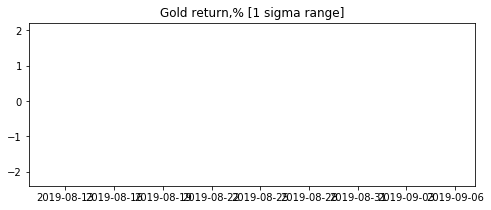

In [560]:
fig = plt.figure(figsize=(8,3))
plt.title('Gold return,% [1 sigma range]')
camera = Camera(fig)

for i in range((len(df)-20),len(df)):
    
    ms='or' if (df['return'].values[i]>u or df['return'].values[i]<l) else 'oy'
    plt.plot(df['return'].index[i],df['return'].values[i],ms,markersize=8)
    
    plt.axhline(y = mean,color='g',linestyle='-')
    plt.axhline(y = u,color='b',linestyle='--')
    plt.axhline(y = l,color='b',linestyle='--')
    
    camera.snap()

animation = camera.animate()
animation.save('series.gif', writer = LoopingPillowWriter(fps=10))  

Check return for stationarity by ADF test: 

In [561]:
z = df['return'].values
result = adfuller(z)

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -53.409458
p-value: 0.000000
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


We can reject the null hypothesis - strongly negative ADF statistic. Look at the ACF for rolling return: 

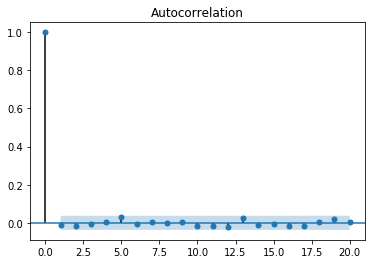

In [562]:
sm.graphics.tsa.plot_acf(df['return'].values, lags=20)
plt.show()

Distribution function reaches equilibrium at n=. We may define the difference of returns in frame of Ornstein–Uhlenbeck process (geometric Brownian motion with drift):

Standartize returns (3):

In [563]:
df_oup=df.copy()
df_oup['return'] = (df_oup['return']-mean)/std
df_oup.dropna(inplace = True)

Define differences (4):

In [564]:
df_oup = df.copy()
df_oup['Difference'] = df_oup['return'].diff() 
df_oup['return'] = df_oup['return'].shift(1,axis = 0)
df_oup.dropna(inplace = True)

Mapping of return-difference hides uncertainty - hidden parameters are probably lost. 
Person correlation and significance of H0 hypothesis:

In [565]:
pc = sc.stats.pearsonr(list(df_oup['return']),list(df_oup['Difference']))

print('Difference vice return correlation (Pearson):',int(100*round(pc[0],2)),'%')
print('Difference vice return 2-tailed p-value:',round(pc[1],2))
print('Difference vice return R2:',round(pc[0]**2,2))

Difference vice return correlation (Pearson): -71 %
Difference vice return 2-tailed p-value: 0.0
Difference vice return R2: 0.5


Scatter plot:

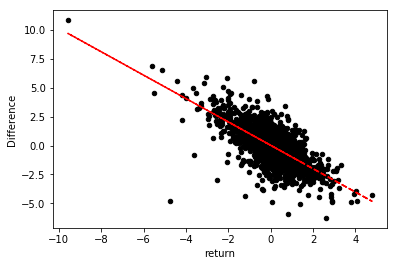

In [566]:
df_oup.plot.scatter(x = 'return',y = 'Difference',color = 'black') 

x = list(df_oup['return'])
y = list(df_oup['Difference'])

z = np.polyfit(x,y,1)
p = np.poly1d(z)

plt.plot(x,p(x),"r--")
plt.show()

Statistics for OLS:

In [567]:
model = sm.OLS(y,x).fit()
print(model.summary().tables[0])
print(model.summary().tables[1])
print(model.summary().tables[2])

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.505
Model:                            OLS   Adj. R-squared:                  0.505
Method:                 Least Squares   F-statistic:                     2852.
Date:                Sun, 08 Sep 2019   Prob (F-statistic):               0.00
Time:                        12:39:57   Log-Likelihood:                -3886.3
No. Observations:                2800   AIC:                             7775.
Df Residuals:                    2799   BIC:                             7781.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -1.0092      0.019    -53.406      0.0

High significance of slope factor. Calcultation of mean reversion decay time - return decreases by 4 times. It is the recommended time of position hold:

In [568]:
reverse_time = int(round(-math.log(4)/p[1]))
print('Mean reversion time:',reverse_time,'day')

Mean reversion time: 1 day


Definition of expected return for decay time after inverse rescaling:

In [569]:
exp_return=0.25*std*df_oup['return'].values[-1]+mean
print('Expected return:',round(exp_return,2),'%')

Expected return: -0.52 %


Define position direction:

In [570]:
direction = ('Long' if exp_return>0 else 'Short')
print('Position direction:',direction)

Position direction: Short


Define the weight of strategy allocation according to Sharpe ratio:

In [571]:
fraction = 100*abs(exp_return)/(3*std)
print('Sharpe weight:',int(round(fraction)),'%')

Sharpe weight: 18 %
